# POLI 175 - Lecture 18

## Non-linearity III and Configuring your DataHub for PS03

In [15]:
## Loading the relevant packages
import pandas as pd
import numpy as np

# Plotting things:
import seaborn as sns
import matplotlib.pyplot as plt

# Look at our friend here to help with GAM
import statsmodels.api as sm
from statsmodels.gam.api import GLMGam, BSplines

# Loading scikit learn relevant packages (note our new friends!)
from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge, Lasso
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.metrics import confusion_matrix, classification_report, precision_score, get_scorer_names, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, LeaveOneOut, cross_val_score, KFold, GridSearchCV
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, SplineTransformer
from sklearn.feature_selection import SequentialFeatureSelector

In [16]:
## Countries Dataset
countr = pd.read_csv('https://raw.githubusercontent.com/umbertomig/POLI175public/main/data/countrdat.csv')
countr.head()

,ccodealp,year,cname,wdi_wip,pwt_pop,wdi_expedu,mad_gdppc
0,ALB,1999,Albania,5.161290,3.122697,3.59293,4432.0426
1,ALB,2000,Albania,5.161290,3.129243,3.43017,4808.4796
2,ALB,2001,Albania,5.714286,3.129704,3.45870,5285.8091
3,ALB,2002,Albania,5.714286,3.126187,3.11780,5608.9623
4,ALB,2003,Albania,5.714286,3.118023,3.13823,6004.6452


In [17]:
## Education Expenditure Dataset
educ = pd.read_csv('https://raw.githubusercontent.com/umbertomig/POLI175public/main/data/educexp.csv')
educ = educ[['education', 'income']]
educ.head()

,education,income
0,189,2824
1,169,3259
2,230,3072
3,168,3835
4,180,3549


## GAMs

- A different way to think about the problem is: Suppose we have $p$ variables. 

- Then, we could have a flexible function for each variable:

$$ y_i \ = \ \beta_0 + f_1(x_{i1}) + f_2(x_{i2}) + \cdots + f_p(x_{ip}) + \varepsilon_i $$

- This is called **Generalized Additive Models**, or **GAMs** for short.

## GAMs

- For each $f$, we can combine natural splines (continuous) and piecewise-constant functions (discrete).

- The book wage example summarizes this well. In here: $ \text{wage} = \beta_0 + f_1(\text{year}) + f_2(\text{age}) + f_3(\text{education}) + \varepsilon $

- $f_1$ and $f_2$ are natural splines; $f_3$ piecewise constant.

![img](../img/gam.png)

## GAMs

**Positives**:

- GAMs are *easy* to interpret: the interpretation of each pattern would be: holding other things constant, this is how $x_j$ affects $y$.

- Non-linear fits can make more accurate predictions.

- Additivity brings a good deal of interpretability to models.

- Smoothness can be summarized by the degrees of freedom consumed in the fit.

- Can be implemented for Logistic Regression (useful for classification!)

## GAMs

**Negatives**:

- Restricted to be additive: Interactions are missed.

- Smoothing splines GAM fit is not trivial (does not use the least square method).

- But there are efficient iterative methods for fitting smoothing splines, so not that bad.

In [18]:
## GAM: Prep the data
y = countr['wdi_wip']
X = countr[['wdi_expedu', 'pwt_pop', 'mad_gdppc']]
X_zed = StandardScaler().set_output(transform = 'pandas').fit_transform(X)
X_zed.head()

,wdi_expedu,pwt_pop,mad_gdppc
0,-0.450176,-0.267807,-0.691774
1,-0.547556,-0.267764,-0.670224
2,-0.530486,-0.267761,-0.642898
3,-0.734450,-0.267784,-0.624399
4,-0.722226,-0.267838,-0.601747


In [19]:
## GAM
bspline = BSplines(X_zed, df=[15, 15, 15], degree=[3, 3, 3])
gam = GLMGam.from_formula('wdi_wip ~ 1', data = countr, smoother = bspline)
## Find best penalty (takes a few hours!)
#gam.select_penweight_kfold()[0]
resgam = gam.fit()
resgam.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                wdi_wip   No. Observations:                 2404
Model:                         GLMGam   Df Residuals:                     2361
Model Family:                Gaussian   Df Model:                        42.00
Link Function:               identity   Scale:                          91.746
Method:                         PIRLS   Log-Likelihood:                -8821.3
Date:                Fri, 24 Feb 2023   Deviance:                   2.1661e+05
Time:                        16:26:55   Pearson chi2:                 2.17e+05
No. Iterations:                     3   Pseudo R-squ. (CS):             0.3317
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         10.2566      8.696      1.179      0.238      -6.788      27.301
wdi_expedu_s0      1.8830     12.733      0.148      0.882     -23.074      26.840
wdi_expedu_s1      5.5980      7.316      0.765      0.444      -8.741      19.937
wdi_expedu_s2      7.5107      8.353      0.899      0.369      -8.860      23.882
wdi_expedu_s3      5.9905      7.925      0.756      0.450      -9.543      21.524
wdi_expedu_s4      8.5851      8.171      1.051      0.293      -7.429      24.599
wdi_expedu_s5      8.8456      8.058      1.098      0.272      -6.948      24.639
wdi_expedu_s6     10.7033      8.143      1.314      0.189      -5.257      26.663
wdi_expedu_s7     10.9205      8.086      1.351      0.177      -4.928      26.769
wdi_expedu_s8     12.3917      8.087      1.532      0.125      -3.458      28.242
wdi_expedu_s9     13.7261      8.050      1.705      0.088      -2.051      29.503
wdi_expedu_s10    10.3249      8.055      1.282      0.200      -5.462      26.112
wdi_expedu_s11    36.2600      8.851      4.097      0.000      18.912      53.608
wdi_expedu_s12    -3.6611     11.079     -0.330      0.741     -25.375      18.052
wdi_expedu_s13    10.7166     10.711      1.001      0.317     -10.276      31.710
pwt_pop_s0       -22.6588      3.430     -6.605      0.000     -29.382     -15.935
pwt_pop_s1        -5.9778      2.235     -2.675      0.007     -10.358      -1.597
pwt_pop_s2       -13.3877      2.667     -5.020      0.000     -18.614      -8.161
pwt_pop_s3        -9.5918      2.147     -4.468      0.000     -13.799      -5.384
pwt_pop_s4        -3.5236      2.250     -1.566      0.117      -7.933       0.885
pwt_pop_s5        -5.4794      2.220     -2.468      0.014      -9.831      -1.128
pwt_pop_s6        -2.8015      2.104     -1.331      0.183      -6.925       1.322
pwt_pop_s7        -1.4710      2.193     -0.671      0.502      -5.768       2.826
pwt_pop_s8       -12.5762      2.207     -5.698      0.000     -16.902      -8.250
pwt_pop_s9         0.9828      2.073      0.474      0.636      -3.081       5.047
pwt_pop_s10       -8.5666      1.893     -4.526      0.000     -12.276      -4.857
pwt_pop_s11       -3.5827      5.645     -0.635      0.526     -14.647       7.481
pwt_pop_s12      -35.3459      9.393     -3.763      0.000     -53.756     -16.936
pwt_pop_s13        2.9550      3.564      0.829      0.407      -4.031       9.941
mad_gdppc_s0       4.9462      5.039      0.982      0.326      -4.930      14.822
mad_gdppc_s1       2.1944      2.834      0.774      0.439      -3.360       7.748
mad_gdppc_s2       4.7607      3.621      1.315      0.189      -2.336      11.857
mad_gdppc_s3       0.8676      3.319      0.261      0.794      -5.637       7.372
mad_gdppc_s4       4.7197      3.536      1.335      0.182      -2.212      11.651
mad_gdppc_s5

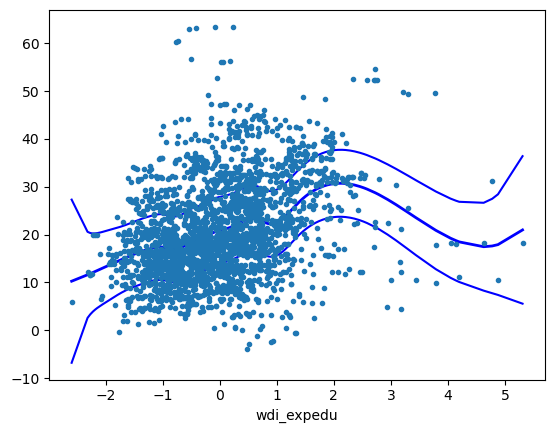

In [6]:
## Education Expenditure
resgam.plot_partial(0, cpr = True)
plt.show()

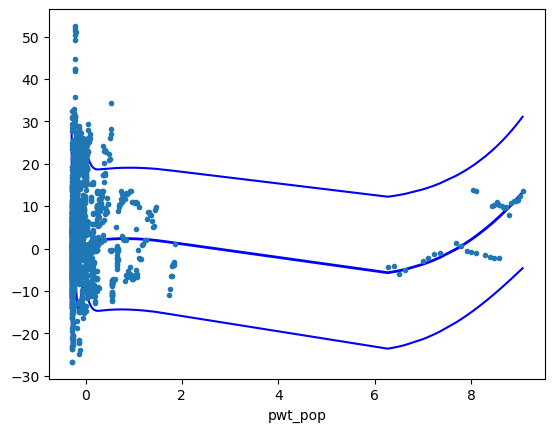

In [7]:
## Population
resgam.plot_partial(1, cpr = True)
plt.show()

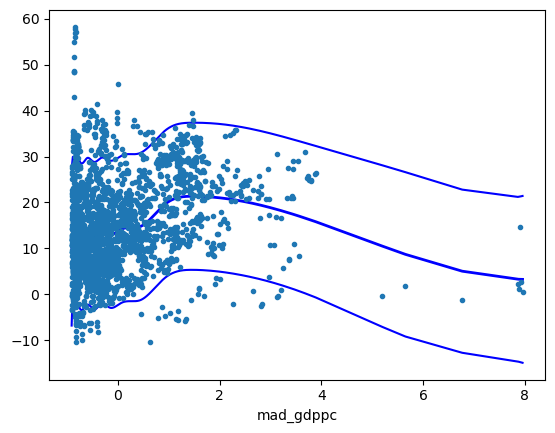

In [8]:
## GDP per capita
resgam.plot_partial(2, cpr = True)
plt.show()

In [9]:
## GAM with FEs for Country and Year
bspline = BSplines(X_zed, df=[15, 15, 15], degree=[3, 3, 3])
gam = GLMGam.from_formula('wdi_wip ~ C(year) + ccodealp', data = countr, smoother = bspline)
## Find best penalty (takes a few hours!)
#gam.select_penweight_kfold()[0]
resgam = gam.fit()
resgam.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                wdi_wip   No. Observations:                 2404
Model:                         GLMGam   Df Residuals:                  2185.00
Model Family:                Gaussian   Df Model:                       218.00
Link Function:               identity   Scale:                          16.558
Method:                         PIRLS   Log-Likelihood:                -6670.2
Date:                Fri, 24 Feb 2023   Deviance:                       36179.
Time:                        15:48:19   Pearson chi2:                 3.62e+04
No. Iterations:                     3   Pseudo R-squ. (CS):             0.9989
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          16.5130     13.847      1.193      0.233     -10.627      43.653
C(year)[T.1998]     0.5394      0.944      0.571      0.568      -1.311       2.390
C(year)[T.1999]     0.5988      0.912      0.657      0.511      -1.189       2.386
C(year)[T.2000]     1.0396      0.906      1.148      0.251      -0.736       2.815
C(year)[T.2001]     2.0181      0.911      2.215      0.027       0.232       3.804
C(year)[T.2002]     2.6822      0.916      2.927      0.003       0.886       4.478
C(year)[T.2003]     3.7086      0.923      4.019      0.000       1.900       5.517
C(year)[T.2004]     4.7384      0.915      5.180      0.000       2.946       6.531
C(year)[T.2005]     5.4053      0.932      5.800      0.000       3.579       7.232
C(year)[T.2006]     5.6519      0.947      5.970      0.000       3.796       7.507
C(year)[T.2007]     7.1269      0.970      7.351      0.000       5.227       9.027
C(year)[T.2008]     7.5808      0.976      7.766      0.000       5.667       9.494
C(year)[T.2009]     7.8593      0.981      8.015      0.000       5.937       9.781
C(year)[T.2010]     8.0459      0.985      8.170      0.000       6.116       9.976
C(year)[T.2011]     8.8399      0.998      8.860      0.000       6.884      10.795
C(year)[T.2012]     9.6479      1.009      9.561      0.000       7.670      11.626
C(year)[T.2013]    10.3127      1.029     10.026      0.000       8.297      12.329
C(year)[T.2014]    10.8624      1.040     10.444      0.000       8.824      12.901
C(year)[T.2015]    11.1867      1.051     10.648      0.000       9.128      13.246
C(year)[T.2016]    11.5630      1.062     10.886      0.000       9.481      13.645
C(year)[T.2017]    11.8338      1.081     10.951      0.000       9.716      13.952
C(year)[T.2018]    12.3643      1.100     11.242      0.000      10.209      14.520
ccodealp[T.ALB]   -11.8859      3.616     -3.287      0.001     -18.973      -4.799
ccodealp[T.ARE]    -2.0219      3.502     -0.577      0.564      -8.886       4.843
ccodealp[T.ARG]     3.9007      2.287      1.706      0.088      -0.582       8.383
ccodealp[T.ARM]   -17.2406      3.573     -4.826      0.000     -24.243     -10.239
ccodealp[T.AUS]     2.4639      2.683      0.918      0.358      -2.795       7.722
ccodealp[T.AUT]     9.3979      2.987      3.146      0.002       3.544      15.252
ccodealp[T.AZE]   -10.7791      2.327     -4.633      0.000     -15.339      -6.219
ccodealp[T.BDI]     7.6644      2.738      2.799      0.005       2.298      13.031
ccodealp[T.BEL]    11.2278      2.833      3.963      0.000       5.674      16.781
ccodealp[T.BEN]   -14.8240      2.451     -6.048      0.000     -19.628     -10.020
ccodealp[T.BFA]   -13.5663      2.293     -5.915      0.000     -18.061      -9.071
ccodealp[T.BGD]   -33.9612      4.740     -7.165      0.000

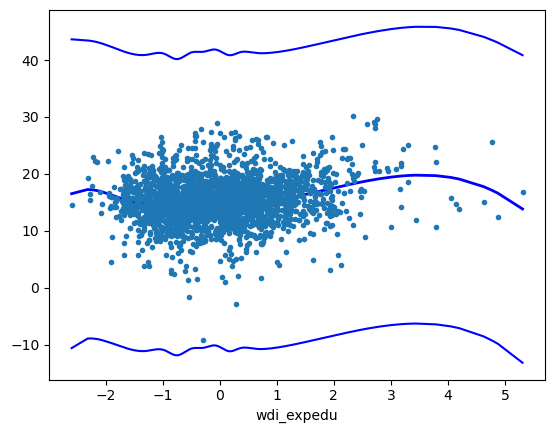

In [10]:
## Education Expenditure
resgam.plot_partial(0, cpr = True)
plt.show()

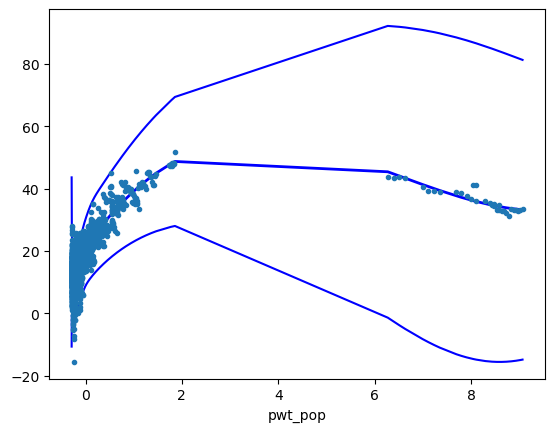

In [11]:
## Population
resgam.plot_partial(1, cpr = True)
plt.show()

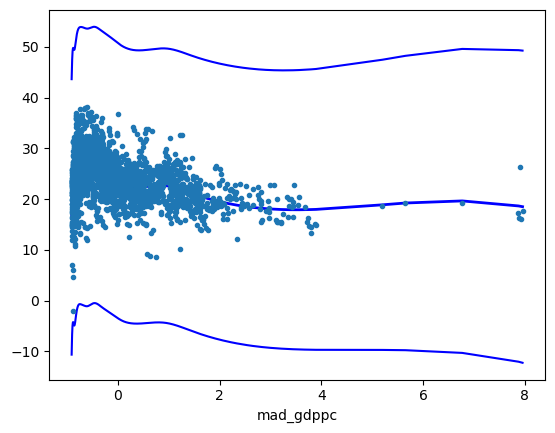

In [12]:
## GDP per capita
resgam.plot_partial(2, cpr = True)
plt.show()

# Configure DataHub for PS 03



## Configure DataHub for PS 03

1. Open Terminal.

2. Type:

```
mkdir mykernel
python3 -m venv mykernel
source mykernel/bin/activate
```

## Configure DataHub for PS 03

3. Then, type:

```
which pip # output = /datasets/home/…/<your-user-here>/mykernel/bin/pip

/home/<your-user-here>/mykernel/bin/python3 -m pip install --upgrade pip
```

Substituting the **\<your-user-here\>** for your actual username.

## Configure DataHub for PS 03

4. Now, let's get all the good and new stuff installed:

```
pip install ipython ipykernel

pip install scikit-learn

pip install seaborn

pip install statsmodels
```

## Configure DataHub for PS 03

4. Finally, let us be done with it and restart:

```
which ipython # output = /datasets/home/.../<your-user-here>/mykernel/bin/pip/ipython

ipython kernel install --user --name=mykernel

deactivate
```

Again, substituting the **\<your-user-here\>** for your username.

5. Close and open again your DataHub, now you have all up-to-date!

# Questions?

# See you next class
